In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
# from paths import mkl_data
import requests # API library

import random
import time
import os

from isoweek import Week

import requests # API library

import numpy as np
import pandas as pd
import json
import re

import torch
import pyro
import pyro.distributions as dist
from pyro.contrib.autoguide import AutoDiagonalNormal, AutoMultivariateNormal
from pyro.infer import MCMC, NUTS, HMC, SVI, Trace_ELBO
from pyro.optim import Adam, ClippedAdam
from pyro.infer import Predictive



/var/folders/bx/n7x8tlw17p9_m_8d4g08505w0000gn/T/ipykernel_6066/2758595007.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd
/Users/fluffysnail/Library/CloudStorage/OneDrive-Personal/dtu/current/42186_modelml/42186_venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
#Expects an observation from df
def model2(obs):
    hyper_sigma = 1/8
    #
    coach1_mu_skill = 0
    coach1_sigma_skill = 1
    coach1_skill = pyro.sample("coach1_skill", dist.Normal(coach1_mu_skill, coach1_sigma_skill))
    coach2_mu_skill = 0
    coach2_sigma_skill = 1
    coach2_skill = pyro.sample("coach2_skill", dist.Normal(coach2_mu_skill, coach2_sigma_skill))
    
    with pyro.plate('matches', obs.shape[0]):   

        coach1_perf = pyro.sample('coach1_perf', dist.Normal(coach1_skill, hyper_sigma))
        coach2_perf = pyro.sample('coach2_perf', dist.Normal(coach2_skill, hyper_sigma))

        perf_diff = coach1_perf - coach2_perf
    
        y = pyro.sample("y_coach1_win", dist.Normal(perf_diff, hyper_sigma), obs=obs)

    return y

In [4]:
optimizer = Adam({"lr": 0.01})
guide = AutoDiagonalNormal(model2)
svi = SVI(model2, guide, optimizer, loss=Trace_ELBO())

# Training loop
num_steps = 5000
#This is fake data, just show that the model can be trained
obs = torch.tensor([1,1,1,1,1,1,1,1,1,1,1,1])
for step in range(num_steps):    
    #Feed in batches (e.g. batches of observations)
    loss = svi.step(obs)
    if step % 100 == 0:
        print(f"Step {step} : loss = {loss}")




Step 0 : loss = 297.0240622162819
Step 100 : loss = -0.40923750400543213
Step 200 : loss = -2.0924947261810303
Step 300 : loss = 0.6893655061721802
Step 400 : loss = -0.655463695526123
Step 500 : loss = -0.818579912185669
Step 600 : loss = 7.079321980476379
Step 700 : loss = 5.716830134391785
Step 800 : loss = 0.2787439823150635
Step 900 : loss = 0.44478631019592285
Step 1000 : loss = 1.3927888870239258
Step 1100 : loss = 3.563556432723999
Step 1200 : loss = 5.524590075016022
Step 1300 : loss = 0.3623034954071045
Step 1400 : loss = 3.315456986427307
Step 1500 : loss = -0.33500826358795166
Step 1600 : loss = 2.60115647315979
Step 1700 : loss = 2.962277889251709
Step 1800 : loss = 5.835680961608887
Step 1900 : loss = 11.287555456161499
Step 2000 : loss = -0.038440823554992676
Step 2100 : loss = 4.057755351066589
Step 2200 : loss = 2.1624810695648193
Step 2300 : loss = 4.32693874835968
Step 2400 : loss = 0.8838880062103271
Step 2500 : loss = 0.592665433883667
Step 2600 : loss = 0.96244442

In [7]:
from pyro.infer import Predictive

#This is an example of inference after training
predictive = Predictive(model2, guide=guide, num_samples=2000,
                        return_sites=("coach1_skill", "coach2_skill"))

samples = predictive(obs)


/var/folders/bx/n7x8tlw17p9_m_8d4g08505w0000gn/T/ipykernel_6066/3397869349.py:10: MatplotlibDeprecationWarning: An artist whose label starts with an underscore was passed to legend(); such artists will no longer be ignored in the future.  To suppress this warning, explicitly filter out such artists, e.g. with `[art for art in artists if not art.get_label().startswith('_')]`.
  plt.legend("c1_skill", "c2_skill")
/var/folders/bx/n7x8tlw17p9_m_8d4g08505w0000gn/T/ipykernel_6066/3397869349.py:10: UserWarning: Legend does not support handles for str instances.
A proxy artist may be used instead.
See: https://matplotlib.org/stable/users/explain/axes/legend_guide.html#controlling-the-legend-entries
  plt.legend("c1_skill", "c2_skill")


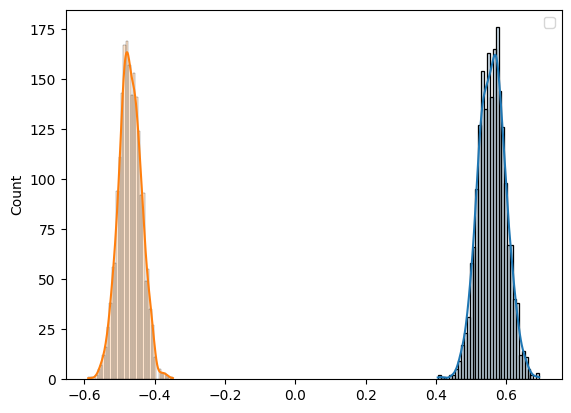

In [8]:
import seaborn as sns

#Plotting the data
coach1_skill_inf = samples["coach1_skill"].detach().squeeze()
coach2_skill_inf= samples["coach2_skill"].detach().squeeze()

sns.histplot(coach1_skill_inf, kde=True, alpha=0.2)
sns.histplot(coach2_skill_inf, kde=True, alpha=0.2)

plt.legend("c1_skill", "c2_skill")
plt.show()